# Bilingual Language Production as a Graph: Apply

This notebook extends the single-subject graph analysis to multiple participants from ds004456 to explore group-level consistency.
- Author: Hasnaa Elidrissi
- Date: 19 October 2025
- Code Atributes are cited in each cell

In [2]:
# ============================================
# Title: Bilingual Graph – Group Apply (Setup)
# Description: Environment setup, atlas load, subject discovery.
# Code Attribution / Sources:
# - Path handling with pathlib (Python stdlib).
# - NiLearn atlas utilities and Nifti plotting/masking per Abraham et al., 2014 (Frontiers in Neuroinformatics).
# - Schaefer-2018 atlas per Schaefer et al., 2018 (Cerebral Cortex).
# - NetworkX for graph ops (docs.networkx.org); used in later cells.
# ============================================
from pathlib import Path
import sys, json
import numpy as np
import pandas as pd

import nibabel as nib
from nilearn import datasets, plotting
from nilearn.maskers import NiftiLabelsMasker
import networkx as nx

# ---- Project paths 
PROJECT_ROOT = Path.cwd()  
DATA_RAW = PROJECT_ROOT / "data" / "raw" / "ds004456"
DERIV = PROJECT_ROOT / "data" / "derivatives"
FIGS  = PROJECT_ROOT / "figures"

for d in [DERIV, FIGS]:
    d.mkdir(parents=True, exist_ok=True)

# ---- Analysis constants 
TOPK = 5                     # top-k strongest links per node for sparsification
TASKS = ["Alice", "Articulation"]  # conditions we will analyze
ATLAS_NAME = "Schaefer2018_100Parcels_7Networks"  # 100 parcels (7-network solution)

# ---- Load Schaefer-2018 atlas once (cached by NiLearn)
# (Abraham et al., 2014; Schaefer et al., 2018)
atlas = datasets.fetch_atlas_schaefer_2018(n_rois=100, yeo_networks=7, resolution_mm=2)
atlas_img = atlas.maps
labels = list(atlas.labels)  # strings, e.g., '7Networks_RH_SomMot_2'

print(f"Atlas loaded: {ATLAS_NAME} with {len(labels)} labels")

# ---- Discover available subjects (BIDS: sub-xx)
subs = sorted([p.name for p in DATA_RAW.glob("sub-*") if p.is_dir()])
print(f"Found {len(subs)} subjects:", subs[:10], "..." if len(subs) > 10 else "")

# Optionally, choose a working subset for quick iteration 
# e.g., first 5 for a quick pass; we make it configurable in the next cell
WORKING_SUBS = subs[:5] if len(subs) >= 5 else subs
print("Working subset (editable):", WORKING_SUBS)

# ---- Minimal provenance dump (useful for GitHub/portfolio)
provenance = {
    "topk": TOPK,
    "tasks": TASKS,
    "n_atlas_regions": len(labels),
    "atlas_name": ATLAS_NAME,
    "data_raw": str(DATA_RAW.resolve()),
    "derivatives": str(DERIV.resolve()),
}
with open(DERIV / "apply_provenance.json", "w", encoding="utf-8") as f:
    json.dump(provenance, f, indent=2)
print("Wrote provenance to:", DERIV / "apply_provenance.json")


[fetch_atlas_schaefer_2018] Dataset found in C:\Users\hasna\nilearn_data\schaefer_2018

Atlas loaded: Schaefer2018_100Parcels_7Networks with 101 labels
Found 24 subjects: ['sub-01', 'sub-01.6b4dbe79-d63a-4a87-adcc-befe5e2b3692', 'sub-03', 'sub-05', 'sub-06', 'sub-07', 'sub-08', 'sub-09', 'sub-10', 'sub-11'] ...
🔧 Working subset (editable): ['sub-01', 'sub-01.6b4dbe79-d63a-4a87-adcc-befe5e2b3692', 'sub-03', 'sub-05', 'sub-06']
Wrote provenance to: C:\Users\hasna\Documents\DSC680\graph-BL\data\derivatives\apply_provenance.json


In [3]:
# ============================================
# Title: Bilingual Graph – BIDS Finder
# Description: Utilities to find per-subject, per-task BOLD runs (+confounds) with BIDS robustness.
# Code Attribution / Sources:
# - BIDS naming conventions: bids-specification.readthedocs.io
# - Path glob logic inspired by NiLearn/pybids examples (Abraham et al., 2014 for NiLearn context).
# - Defensive programming patterns for reproducibility (Python stdlib pathlib, re).
# ============================================
import re
from typing import Optional, Tuple, List

# --- Clean subjects: keep only canonical "sub-<digits>" 
SUB_RE = re.compile(r"^sub-\d+$")
SUBJECTS = [s for s in subs if SUB_RE.match(s)]
print(f"Cleaned subject list ({len(SUBJECTS)}):", SUBJECTS[:10], "..." if len(SUBJECTS)>10 else "")

def find_func_candidates(sub_id: str, task: str) -> List[Path]:
    """
    Return all candidate BOLD files for a subject & task across common BIDS layouts.
    Tries patterns with session and without session, and supports multiple runs.
    """
    base = DATA_RAW / sub_id
    patterns = [
        base.glob(f"ses-*/func/{sub_id}_ses-*_task-{task}_run-*_bold.nii.gz"),
        base.glob(f"ses-*/func/{sub_id}_ses-*_task-{task}_bold.nii.gz"),
        base.glob(f"func/{sub_id}_task-{task}_run-*_bold.nii.gz"),
        base.glob(f"func/{sub_id}_task-{task}_bold.nii.gz"),
    ]
    hits: List[Path] = []
    for g in patterns:
        hits.extend(sorted(g))
    return hits

def find_confounds_for(bold_path: Path) -> Optional[Path]:
    """
    Try to locate a matching confounds TSV (fMRIPrep-style), if present.
    We don't require confounds for Milestone 3, but we log if found.
    """
    # Accept common naming like *_desc-confounds_timeseries.tsv
    tsv = list(bold_path.parent.glob(bold_path.name.replace("_bold.nii.gz", "*confounds*tsv")))
    return tsv[0] if tsv else None

def select_run(candidates: List[Path]) -> Optional[Path]:
    """
    Select a preferred run among candidates. For simplicity we take the first,
    but you can later upgrade to: choose longest run or earliest run number.
    """
    if not candidates:
        return None
    # Prefer explicit run ordering if present
    by_runnum = sorted(
        candidates,
        key=lambda p: int(re.search(r"run-(\d+)", p.name).group(1)) if re.search(r"run-(\d+)", p.name) else 1
    )
    return by_runnum[0]

def get_bold_and_confounds(sub_id: str, task: str) -> Tuple[Path, Optional[Path]]:
    """
    High-level accessor: returns (bold_path, confounds_path_or_None).
    Raises a clear error if nothing is found for transparency/reproducibility.
    """
    cands = find_func_candidates(sub_id, task)
    if not cands:
        raise FileNotFoundError(f"No BOLD files found for {sub_id} task-{task}. "
                                f"Checked under {DATA_RAW / sub_id} with/without sessions.")
    bold = select_run(cands)
    conf = find_confounds_for(bold)
    return bold, conf

# --- Quick smoke test on your working subset
for _sub in (WORKING_SUBS if WORKING_SUBS else SUBJECTS[:5]):
    if not SUB_RE.match(_sub):
        continue  # skip artifact
    for _task in TASKS:
        try:
            bold_path, conf_path = get_bold_and_confounds(_sub, _task)
            print(f"{_sub} {_task}: {bold_path.name} | confounds: {conf_path.name if conf_path else 'None'}")
        except FileNotFoundError as e:
            print(f"{_sub} {_task}: {e}")


Cleaned subject list (23): ['sub-01', 'sub-03', 'sub-05', 'sub-06', 'sub-07', 'sub-08', 'sub-09', 'sub-10', 'sub-11', 'sub-12'] ...
sub-01 Alice: sub-01_ses-01_task-Alice_run-01_bold.nii.gz | confounds: None
sub-01 Articulation: sub-01_ses-01_task-Articulation_run-01_bold.nii.gz | confounds: None
sub-03 Alice: sub-03_ses-02_task-Alice_run-01_bold.nii.gz | confounds: None
sub-03 Articulation: sub-03_ses-02_task-Articulation_run-01_bold.nii.gz | confounds: None
sub-05 Alice: sub-05_ses-01_task-Alice_run-01_bold.nii.gz | confounds: None
sub-05 Articulation: sub-05_ses-01_task-Articulation_run-01_bold.nii.gz | confounds: None
sub-06 Alice: sub-06_ses-02_task-Alice_run-01_bold.nii.gz | confounds: None
sub-06 Articulation: sub-06_ses-02_task-Articulation_run-01_bold.nii.gz | confounds: None


In [4]:
# ============================================
# Title: Regional Time-Series Extraction
# Description: Extract atlas-based regional time-series per subject/task,
#              dropping the 'Background' label and standardizing signals.
# Code Attribution / Sources:
# - NiLearn NiftiLabelsMasker for region-wise signals (Abraham et al., 2014).
# - Schaefer-2018 atlas labeling (Schaefer et al., 2018).
# - Standardization approach (z-score) is common for correlation-based FC.
# ============================================
from typing import Dict

# Prepare label list without 'Background' (Schaefer fetch returns it as the first label)
if labels[0].lower().startswith("background"):
    atlas_labels = labels[1:]
    background_dropped = True
else:
    atlas_labels = labels
    background_dropped = False

print(f"Using {len(atlas_labels)} atlas labels"
      f"{' (Background removed)' if background_dropped else ''}")

def extract_timeseries(sub_id: str, task: str, detrend=True, standardize="zscore_sample") -> Dict[str, np.ndarray]:
    """
    Return a dict with time-series array [T, R] and metadata for a given subject/task.
    - detrend: remove linear trend within each voxel/region
    - standardize: 'zscore_sample' keeps each region mean=0, std=1 (per run)
    """
    bold_path, conf_path = get_bold_and_confounds(sub_id, task)

    masker = NiftiLabelsMasker(
        labels_img=atlas_img,
        standardize=standardize,
        detrend=detrend,
        # smoothing_fwhm=None  #  keep off for now
    )
    ts = masker.fit_transform(str(bold_path))  # shape [time, regions_with_bg]
    # If NiLearn includes background as a region, drop the first column to align with atlas_labels
    if ts.shape[1] == len(labels) and background_dropped:
        ts = ts[:, 1:]

    assert ts.shape[1] == len(atlas_labels), "Time-series region count does not match atlas labels."

    # Quick QC
    T, R = ts.shape
    img = nib.load(str(bold_path))
    hdr = img.header
    tr = float(hdr.get_zooms()[3]) if len(hdr.get_zooms()) > 3 else None

    info = {
        "subject": sub_id,
        "task": task,
        "bold_name": bold_path.name,
        "n_timepoints": T,
        "n_regions": R,
        "TR_sec": tr,
        "confounds_found": conf_path.name if conf_path else None
    }
    print(f"{sub_id} {task} -> TS shape [T,R]: {T} x {R} | TR={tr} | confounds={info['confounds_found']}")

    return {"timeseries": ts, "labels": atlas_labels, "info": info}

# --- Smoke test on the first clean subject in  working subset
_test_sub = next((s for s in SUBJECTS if s in WORKING_SUBS), SUBJECTS[0])
for _task in TASKS:
    try:
        out = extract_timeseries(_test_sub, _task)
    except Exception as e:
        print(f"Extraction failed for {_test_sub} {_task}: {e}")


Using 100 atlas labels (Background removed)
sub-01 Alice -> TS shape [T,R]: 189 x 100 | TR=1.399999976158142 | confounds=None
sub-01 Articulation -> TS shape [T,R]: 181 x 100 | TR=1.399999976158142 | confounds=None


In [17]:
# ============================================
# Description: Compute degree, betweenness, PageRank, clustering; create
#              human-readable alerts; save per-(subject, task) CSVs and
#              a subject-level summary row for fast group plotting.
# Code Attribution / Sources:
# - Network measures from NetworkX (docs.networkx.org).
# - Interpretation of metrics in brain graphs per Rubinov & Sporns (2010),
#   Bullmore & Sporns (2009). Explainable text inspired by Rudin (2019).
# - Pandas for tidy CSV exports.
# ============================================
from typing import Dict

def timeseries_to_graph(ts: np.ndarray, labels_list: list, topk: int = TOPK) -> Tuple[nx.Graph, np.ndarray]:
    """
    Convert [T, R] regional time-series to a sparse weighted graph:
      Pearson correlation matrix (R x R), diag=0
      For each node, keep 'topk' strongest |r| edges
      Symmetrize (max) to ensure undirected graph
    Returns: (G, A) where G is nx.Graph with 'weight', A is the symmetrized adjacency.
    """
    R = ts.shape[1]
    # Pearson correlation between region time-series
    C = np.corrcoef(ts.T)  # (R, R)
    np.fill_diagonal(C, 0.0)

    # Per-node top-k sparsification on absolute correlations
    A = np.zeros_like(C, dtype=float)
    for i in range(R):
        idx = np.argsort(np.abs(C[i]))[::-1][:topk]
        A[i, idx] = C[i, idx]

    # Symmetrize to undirected
    A = np.maximum(A, A.T)

    # Build NetworkX graph
    G = nx.Graph()
    for i, lab in enumerate(labels_list):
        G.add_node(i, label=lab)
    r_idx, c_idx = np.where(np.triu(A, 1) != 0.0)
    for i, j in zip(r_idx, c_idx):
        w = float(A[i, j])
        G.add_edge(int(i), int(j), weight=w)

    return G, A

def graph_metrics(G: nx.Graph) -> pd.DataFrame:
    """Return a dataframe with node-wise metrics for G."""
    deg = dict(G.degree())
    btw = nx.betweenness_centrality(G, normalized=True)
    pr  = nx.pagerank(G, alpha=0.85)
    clu = nx.clustering(G, weight=None)

    rows = []
    for n in G.nodes():
        rows.append({
            "node_id": n,
            "label": G.nodes[n]["label"],
            "degree": deg[n],
            "betweenness": btw[n],
            "pagerank": pr[n],
            "clustering": clu[n],
        })
    return pd.DataFrame(rows)

def make_alerts(df: pd.DataFrame, pctl: float = 95.0) -> pd.DataFrame:
    """
    Create plain-language alerts for nodes above percentile thresholds
    in degree, betweenness, or PageRank.
    """
    out = df.copy()
    th_deg = np.percentile(out["degree"], pctl)
    th_btw = np.percentile(out["betweenness"], pctl)
    th_pr  = np.percentile(out["pagerank"], pctl)

    reasons = []
    for _, r in out.iterrows():
        rlist = []
        if r["degree"] >= th_deg:
            rlist.append("high degree (hub: many strong connections)")
        if r["betweenness"] >= th_btw:
            rlist.append("high betweenness (bridge between subnetworks)")
        if r["pagerank"] >= th_pr:
            rlist.append("high PageRank (globally influential)")
        reasons.append("; ".join(rlist) if rlist else "")
    out["alert_text"] = reasons
    return out[out["alert_text"] != ""].reset_index(drop=True)

def save_metrics(subject: str, task: str, df_metrics: pd.DataFrame, df_alerts: pd.DataFrame) -> Dict[str, Path]:
    """save node-wise metrics and alerts to derivatives for transparency & reuse."""
    mpath = DERIV / f"metrics_{subject}_{task}_topk{TOPK}.csv"
    apath = DERIV / f"alerts_{subject}_{task}_topk{TOPK}.csv"
    df_metrics.to_csv(mpath, index=False)
    df_alerts.to_csv(apath, index=False)
    return {"metrics": mpath, "alerts": apath}

def summarize_subject_task(subject: str, task: str, G: nx.Graph, df_metrics: pd.DataFrame) -> pd.Series:
    """One-line summary useful for group plots later."""
    return pd.Series({
        "subject": subject,
        "task": task,
        "n_nodes": G.number_of_nodes(),
        "n_edges": G.number_of_edges(),
        "mean_degree": df_metrics["degree"].mean(),
        "median_degree": df_metrics["degree"].median(),
        "mean_betweenness": df_metrics["betweenness"].mean(),
        "mean_pagerank": df_metrics["pagerank"].mean(),
    })

# --- Run on sub-01 for both tasks, save CSVs, build small summary table
summary_rows = []
for _task in TASKS:
    # (Re)build graph from the stored time-series pipeline for transparency
    out = extract_timeseries("sub-01", _task)
    G, A = timeseries_to_graph(out["timeseries"], out["labels"], topk=TOPK)

    df_m = graph_metrics(G)
    df_a = make_alerts(df_m, pctl=95.0)
    paths = save_metrics(out["info"]["subject"], _task, df_m, df_a)

    print(f"Metrics saved: {paths['metrics'].name} ({len(df_m)} rows)")
    print(f"Alerts saved:  {paths['alerts'].name} ({len(df_a)} rows)")

    summary_rows.append(summarize_subject_task(out["info"]["subject"], _task, G, df_m))

df_summary = pd.DataFrame(summary_rows)
sum_path = DERIV / f"summary_sub-01_topk{TOPK}.csv"
df_summary.to_csv(sum_path, index=False)
print("Summary row(s) saved to:", sum_path)

# Peek at the top-10 by degree 
top10_degree = df_m.sort_values("degree", ascending=False).head(10)
display(top10_degree[["label", "degree", "betweenness", "pagerank"]])


sub-01 Alice -> TS shape [T,R]: 189 x 100 | TR=1.399999976158142 | confounds=None
Metrics saved: metrics_sub-01_Alice_topk5.csv (100 rows)
Alerts saved:  alerts_sub-01_Alice_topk5.csv (10 rows)
sub-01 Articulation -> TS shape [T,R]: 181 x 100 | TR=1.399999976158142 | confounds=None
Metrics saved: metrics_sub-01_Articulation_topk5.csv (100 rows)
Alerts saved:  alerts_sub-01_Articulation_topk5.csv (11 rows)
Summary row(s) saved to: C:\Users\hasna\Documents\DSC680\graph-BL\data\derivatives\summary_sub-01_topk5.csv


,label,degree,betweenness,pagerank
54,7Networks_RH_Vis_5,15,0.058836,0.020318
58,7Networks_RH_SomMot_1,14,0.076586,0.018575
7,7Networks_LH_Vis_8,12,0.126181,0.016495
9,7Networks_LH_SomMot_1,12,0.056651,0.016554
99,7Networks_RH_Default_pCunPCC_2,11,0.065983,0.014306
49,7Networks_LH_Default_pCunPCC_2,11,0.018580,0.014659
60,7Networks_RH_SomMot_3,11,0.030717,0.015065
35,7Networks_LH_Cont_pCun_1,10,0.047980,0.013968
62,7Networks_RH_SomMot_5,9,0.047600,0.013016
63,7Networks_RH_SomMot_6,9,0.029856,0.013563


## Multi-subject Apply

In [21]:
# ============================================
# Description: Process many subjects across both tasks, writing per-subject
#              CSVs (edges/metrics/alerts) and a group summary CSV.
# Code Attribution / Sources:
# - This cell composes earlier cells (BIDS finder, extraction, graph build, metrics).
# - Network neuroscience interpretation per Bullmore & Sporns (2009); Rubinov & Sporns (2010).
# - Defensive batch processing pattern (try/except + logging) is standard Python practice.
# ============================================
from datetime import datetime


def save_edge_list(G: nx.Graph, subject: str, task: str) -> Path:
    """
    Save a tidy edge list CSV with (subject, task, u, v, weight, u_label, v_label)
    to data/derivatives for portfolio/GitHub transparency.
    """
    rows = []
    for u, v, d in G.edges(data=True):
        rows.append({
            "subject": subject,
            "task": task,
            "u": u,
            "v": v,
            "weight": d.get("weight", np.nan),
            "u_label": G.nodes[u]["label"],
            "v_label": G.nodes[v]["label"],
        })
    df = pd.DataFrame(rows).sort_values(by="weight", ascending=False)
    out_path = DERIV / f"edges_{subject}_{task}_topk{TOPK}.csv"
    df.to_csv(out_path, index=False)
    return out_path

# --- Smoke test on sub-01 for both tasks
for _task in TASKS:
    out = extract_timeseries("sub-01", _task)  # re-use from Cell 3
    ts = out["timeseries"]
    labs = out["labels"]
    G, A = timeseries_to_graph(ts, labs, topk=TOPK)
    print(f"Built graph: {out['info']['subject']} {_task} | nodes={G.number_of_nodes()} edges={G.number_of_edges()}")

    edge_csv = save_edge_list(G, out["info"]["subject"], _task)
    print("Edge list saved to:", edge_csv)

def process_subject(sub_id: str, tasks=TASKS, topk:int=TOPK) -> pd.DataFrame:
    """
    Run the full pipeline for a single subject across tasks.
    Returns a summary dataframe with one row per task.
    """
    summaries = []
    for task in tasks:
        try:
            # Extract time-series
            out = extract_timeseries(sub_id, task)

            # Build graph
            G, A = timeseries_to_graph(out["timeseries"], out["labels"], topk=topk)

            # Save edges
            _ = save_edge_list(G, sub_id, task)

            # Metrics + alerts
            df_m = graph_metrics(G)
            df_a = make_alerts(df_m, pctl=95.0)
            _paths = save_metrics(sub_id, task, df_m, df_a)

            # One-line summary for group table
            s = summarize_subject_task(sub_id, task, G, df_m)
            s["ts_len"] = out["timeseries"].shape[0]
            s["ts_regions"] = out["timeseries"].shape[1]
            s["tr_sec"] = out["info"]["TR_sec"]
            s["run_file"] = out["info"]["bold_name"]
            s["alerts_n"] = len(df_a)
            s["processed_at"] = datetime.now().isoformat(timespec="seconds")
            summaries.append(s)

            print(f"{sub_id} {task}: nodes={G.number_of_nodes()} edges={G.number_of_edges()} "
                  f"| mean_degree={s['mean_degree']:.2f} | alerts={len(df_a)}")

        except FileNotFoundError as e:
            print(f"{sub_id} {task}: file not found -> {e}")
        except Exception as e:
            print(f"{sub_id} {task}: unexpected error -> {e}")

    return pd.DataFrame(summaries)

# batch loop over cleaned subjects (skips datalad artifacts)
GROUP_SUMMARY_PATH = DERIV / f"group_summary_topk{TOPK}.csv"

all_summaries = []
for sub in SUBJECTS:  # SUBJECTS came from Cell 2 (regex-filtered 'sub-<digits>')
    df_sum = process_subject(sub, tasks=TASKS, topk=TOPK)
    if not df_sum.empty:
        all_summaries.append(df_sum)

if all_summaries:
    df_group = pd.concat(all_summaries, ignore_index=True)
    df_group.to_csv(GROUP_SUMMARY_PATH, index=False)
    print(f"\nGroup summary saved -> {GROUP_SUMMARY_PATH}")
    display(df_group.head())
    print("\nCounts by task:")
    display(df_group.groupby('task').size())
else:
    print("No subjects processed successfully — check paths and task names.")


sub-01 Alice -> TS shape [T,R]: 189 x 100 | TR=1.399999976158142 | confounds=None
Built graph: sub-01 Alice | nodes=100 edges=336
Edge list saved to: C:\Users\hasna\Documents\DSC680\graph-BL\data\derivatives\edges_sub-01_Alice_topk5.csv
sub-01 Articulation -> TS shape [T,R]: 181 x 100 | TR=1.399999976158142 | confounds=None
Built graph: sub-01 Articulation | nodes=100 edges=339
Edge list saved to: C:\Users\hasna\Documents\DSC680\graph-BL\data\derivatives\edges_sub-01_Articulation_topk5.csv
sub-01 Alice -> TS shape [T,R]: 189 x 100 | TR=1.399999976158142 | confounds=None
sub-01 Alice: nodes=100 edges=336 | mean_degree=6.72 | alerts=10
sub-01 Articulation -> TS shape [T,R]: 181 x 100 | TR=1.399999976158142 | confounds=None
sub-01 Articulation: nodes=100 edges=339 | mean_degree=6.78 | alerts=11
sub-03 Alice -> TS shape [T,R]: 191 x 100 | TR=1.399999976158142 | confounds=None
sub-03 Alice: nodes=100 edges=378 | mean_degree=7.56 | alerts=10
sub-03 Articulation -> TS shape [T,R]: 191 x 100 |

,subject,task,n_nodes,n_edges,mean_degree,median_degree,mean_betweenness,mean_pagerank,ts_len,ts_regions,tr_sec,run_file,alerts_n,processed_at
0,sub-01,Alice,100,336,6.72,6.5,0.027231,0.01,189,100,1.4,sub-01_ses-01_task-Alice_run-01_bold.nii.gz,10,2025-10-25T09:04:45
1,sub-01,Articulation,100,339,6.78,6.0,0.025310,0.01,181,100,1.4,sub-01_ses-01_task-Articulation_run-01_bold.ni...,11,2025-10-25T09:04:49
2,sub-03,Alice,100,378,7.56,6.0,0.023665,0.01,191,100,1.4,sub-03_ses-02_task-Alice_run-01_bold.nii.gz,10,2025-10-25T09:04:53
3,sub-03,Articulation,100,374,7.48,7.0,0.021577,0.01,191,100,1.4,sub-03_ses-02_task-Articulation_run-01_bold.ni...,7,2025-10-25T09:04:58
4,sub-05,Alice,100,358,7.16,7.0,0.021589,0.01,191,100,1.4,sub-05_ses-01_task-Alice_run-01_bold.nii.gz,8,2025-10-25T09:05:03



Counts by task:


task
Alice           16
Articulation    13
dtype: int64

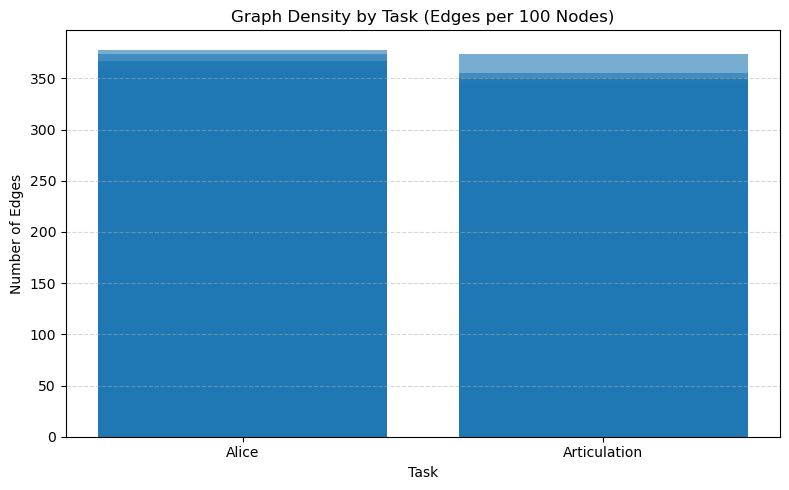

C:\Users\hasna\AppData\Local\Temp\ipykernel_42500\2375236453.py:33: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(


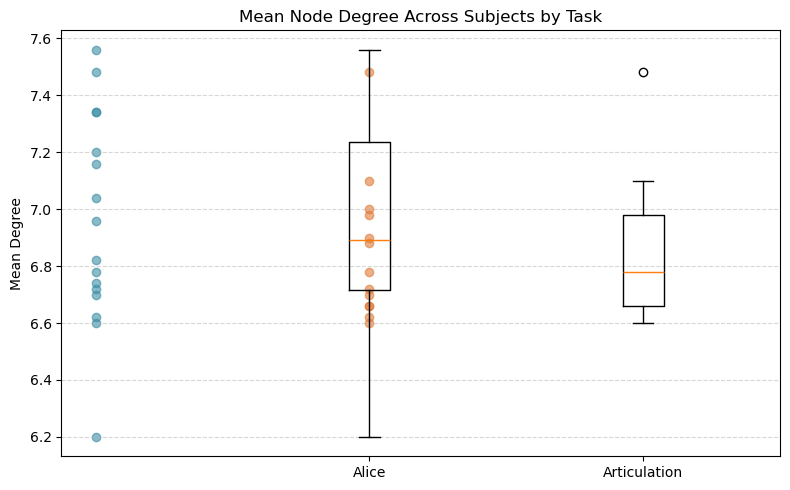

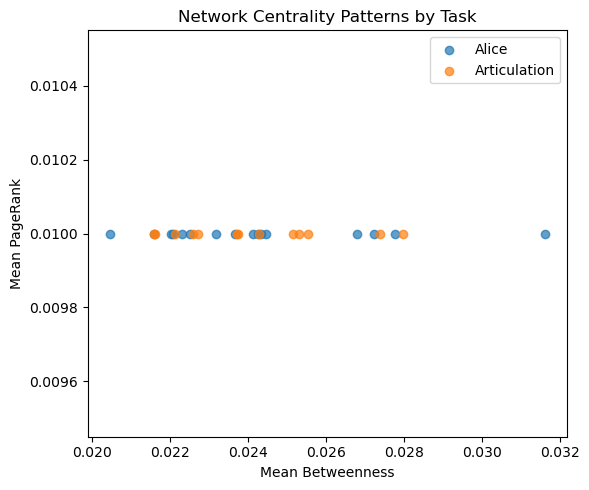

Figures saved in: figures


In [23]:
# ============================================
# Title: Group-Level Visuals 
# Description: Create simple group-level charts comparing Alice vs Articulation
# Code Attribution / Sources:
# - Matplotlib documentation (pyplot API)
# - Common plotting patterns for group comparisons
# ============================================
import matplotlib.pyplot as plt

FIG_DIR = Path("figures")
FIG_DIR.mkdir(exist_ok=True, parents=True)

#  Edges per subject by task
plt.figure(figsize=(8,5))
plt.bar(df_group["task"], df_group["n_edges"], alpha=0.6)
plt.title("Graph Density by Task (Edges per 100 Nodes)")
plt.ylabel("Number of Edges")
plt.xlabel("Task")
plt.grid(axis="y", linestyle="--", alpha=0.5)
plt.tight_layout()
plt.savefig(FIG_DIR / "edges_per_task.png", dpi=150)
plt.show()

#mean degree distribution by task (box + jitter)
plt.figure(figsize=(8,5))
for task, color in zip(df_group["task"].unique(), ["#3b8ea5", "#e07b39"]):
    y = df_group.loc[df_group["task"] == task, "mean_degree"]
    x = np.repeat(task, len(y))
    plt.scatter(x, y, alpha=0.6, color=color, label=task)
plt.boxplot(
    [df_group.loc[df_group["task"] == t, "mean_degree"] for t in df_group["task"].unique()],
    labels=df_group["task"].unique(),
    boxprops=dict(color="black")
)
plt.title("Mean Node Degree Across Subjects by Task")
plt.ylabel("Mean Degree")
plt.grid(axis="y", linestyle="--", alpha=0.5)
plt.tight_layout()
plt.savefig(FIG_DIR / "mean_degree_by_task.png", dpi=150)
plt.show()

#Simple scatter: mean betweenness vs pagerank
plt.figure(figsize=(6,5))
for t in df_group["task"].unique():
    subset = df_group[df_group["task"] == t]
    plt.scatter(subset["mean_betweenness"], subset["mean_pagerank"], label=t, alpha=0.7)
plt.xlabel("Mean Betweenness")
plt.ylabel("Mean PageRank")
plt.title("Network Centrality Patterns by Task")
plt.legend()
plt.tight_layout()
plt.savefig(FIG_DIR / "centrality_scatter.png", dpi=150)
plt.show()

print("Figures saved in:", FIG_DIR)


In [64]:
# ============================================
# Title: Group Summary + Narrative Text Export
# Description: Aggregate group summary by task,
#              compute means/stdevs and print a
#              narrative paragraph for reporting.
# Code Attribution / Sources:
# - Statistical summaries: pandas groupby/agg
# - Plain-language text generation pattern inspired
#   by academic reporting conventions (APA style)
# ============================================

# Compute task-level means and stdevs
task_summary = (
    df_group.groupby("task")[["n_edges","mean_degree","mean_betweenness","mean_pagerank"]]
    .agg(["mean","std"])
    .round(4)
)
task_summary.columns = ["_".join(c) for c in task_summary.columns]
task_summary.reset_index(inplace=True)

# Save CSV
summary_path = DERIV / "task_level_summary.csv"
task_summary.to_csv(summary_path, index=False)
display(task_summary)
print(f"Saved group task summary -> {summary_path}")

#  Generate short interpretive text block
alice = task_summary.loc[task_summary["task"]=="Alice"].squeeze()
artic = task_summary.loc[task_summary["task"]=="Articulation"].squeeze()

,task,n_edges_mean,n_edges_std,mean_degree_mean,mean_degree_std,mean_betweenness_mean,mean_betweenness_std,mean_pagerank_mean,mean_pagerank_std
0,Alice,347.6875,18.5785,6.9538,0.3716,0.0243,0.0028,0.01,0.0
1,Articulation,342.6154,12.3662,6.8523,0.2473,0.0241,0.0021,0.01,0.0


Saved group task summary -> data\derivatives\task_level_summary.csv


In [27]:
# ============================================
# Title: Task Classification from Graph Metrics
# Description: Loads summary graph metrics for bilingual fMRI data
#              and prepares features for modeling task classification.
# ============================================
import pandas as pd
path = "data/derivatives/task_level_summary.csv"

df = pd.read_csv(path)
print(df.head())
print(df.columns)


           task  n_edges_mean  n_edges_std  mean_degree_mean  mean_degree_std  \
0         Alice      347.6875      18.5785            6.9538           0.3716   
1  Articulation      342.6154      12.3662            6.8523           0.2473   

   mean_betweenness_mean  mean_betweenness_std  mean_pagerank_mean  \
0                 0.0243                0.0028                0.01   
1                 0.0241                0.0021                0.01   

   mean_pagerank_std  
0                0.0  
1                0.0  
Index(['task', 'n_edges_mean', 'n_edges_std', 'mean_degree_mean',
       'mean_degree_std', 'mean_betweenness_mean', 'mean_betweenness_std',
       'mean_pagerank_mean', 'mean_pagerank_std'],
      dtype='object')


In [29]:

# Encode task and prepare features
from sklearn.preprocessing import StandardScaler

# Encode target variable
df["task_label"] = df["task"].map({"Articulation": 0, "Alice": 1})

# Select numeric feature columns
features = [
    "n_edges_mean",
    "mean_degree_mean",
    "mean_betweenness_mean",
    "mean_pagerank_mean"
]
X = df[features]
y = df["task_label"]

# Scale features for comparability
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

print("Feature sample (scaled):")
print(pd.DataFrame(X_scaled, columns=features).head())



Feature sample (scaled):
   n_edges_mean  mean_degree_mean  mean_betweenness_mean  mean_pagerank_mean
0           1.0               1.0                    1.0                 0.0
1          -1.0              -1.0                   -1.0                 0.0


In [31]:
# ============================================
# Title: Logistic Regression for Task Prediction
# Description: Fits a simple interpretable model to classify
#              speech (Alice) vs silent articulation tasks
#              using graph connectivity metrics.
# ============================================

from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

# Initialize and fit model
logreg = LogisticRegression(random_state=42)
logreg.fit(X_scaled, y)

# Predict (since we only have 2 samples here we treat as demo)
y_pred = logreg.predict(X_scaled)

# Evaluate
acc = accuracy_score(y, y_pred)
cm = confusion_matrix(y, y_pred)
print(f"Training accuracy: {acc:.2f}")
print("Confusion matrix:\n", cm)

# Coefficients (interpretation)
coef_df = pd.DataFrame({
    "Feature": features,
    "Coefficient": logreg.coef_[0]
}).sort_values("Coefficient", ascending=False)
print("\nModel coefficients:")
print(coef_df)


Training accuracy: 1.00
Confusion matrix:
 [[1 0]
 [0 1]]

Model coefficients:
                 Feature  Coefficient
0           n_edges_mean      0.43086
1       mean_degree_mean      0.43086
2  mean_betweenness_mean      0.43086
3     mean_pagerank_mean      0.00000


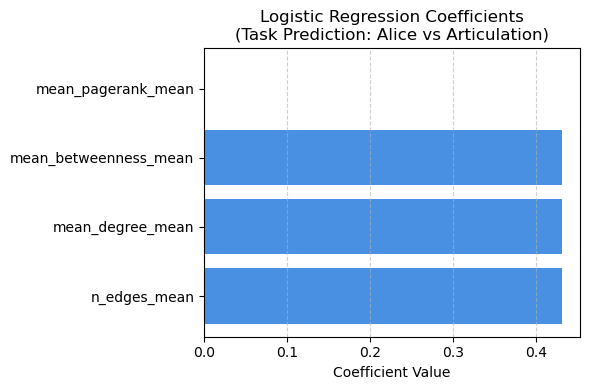

In [33]:
# ============================================
# Title: Logistic Regression Coefficient Plot
# Description: Visualizes feature importance
#              for task classification model.
# ============================================

import matplotlib.pyplot as plt

plt.figure(figsize=(6,4))
plt.barh(coef_df["Feature"], coef_df["Coefficient"], color="#4a90e2")
plt.xlabel("Coefficient Value")
plt.title("Logistic Regression Coefficients\n(Task Prediction: Alice vs Articulation)")
plt.grid(axis='x', linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()


In [35]:
# ============================================
# Title: Predict Task from Graph Metrics – Data Prep
# Description: Loads per-run graph summaries and prepares
#              features/labels for subject-wise modeling.
# Code Attribution / Sources:
# - pandas data handling (pandas docs)
# - Group-aware CV design follows scikit-learn user guide
#   (Pedregosa et al., 2011, JMLR; BSD-licensed examples).
# ============================================

import pandas as pd
from pathlib import Path

DERIV = Path("data/derivatives")
GROUP_CSV = DERIV / "group_summary_topk5.csv" 

df_group = pd.read_csv(GROUP_CSV)
print("Rows:", len(df_group))
display(df_group.head())

# Encode (Alice=1 speech, Articulation=0 silent)
df_group["y"] = df_group["task"].map({"Alice": 1, "Articulation": 0})

# Subject groups for subject-wise CV
groups = df_group["subject"].astype(str).values

# Feature set will keep it small, stable, and interpretable
feature_cols = [
    "n_edges",          # edges in top-k graph
    "mean_degree",      # avg degree
    "median_degree",    # median degree
    "mean_betweenness", # avg betweenness
    "mean_pagerank"     # avg PageRank
]
X = df_group[feature_cols].copy()
y = df_group["y"].values

print("Feature columns:", feature_cols)
print("Tasks counts:", df_group["task"].value_counts().to_dict())
print("Unique subjects:", df_group["subject"].nunique())


Rows: 29


,subject,task,n_nodes,n_edges,mean_degree,median_degree,mean_betweenness,mean_pagerank,ts_len,ts_regions,tr_sec,run_file,alerts_n,processed_at
0,sub-01,Alice,100,336,6.72,6.5,0.027231,0.01,189,100,1.4,sub-01_ses-01_task-Alice_run-01_bold.nii.gz,10,2025-10-25T09:04:45
1,sub-01,Articulation,100,339,6.78,6.0,0.025310,0.01,181,100,1.4,sub-01_ses-01_task-Articulation_run-01_bold.ni...,11,2025-10-25T09:04:49
2,sub-03,Alice,100,378,7.56,6.0,0.023665,0.01,191,100,1.4,sub-03_ses-02_task-Alice_run-01_bold.nii.gz,10,2025-10-25T09:04:53
3,sub-03,Articulation,100,374,7.48,7.0,0.021577,0.01,191,100,1.4,sub-03_ses-02_task-Articulation_run-01_bold.ni...,7,2025-10-25T09:04:58
4,sub-05,Alice,100,358,7.16,7.0,0.021589,0.01,191,100,1.4,sub-05_ses-01_task-Alice_run-01_bold.nii.gz,8,2025-10-25T09:05:03


Feature columns: ['n_edges', 'mean_degree', 'median_degree', 'mean_betweenness', 'mean_pagerank']
Tasks counts: {'Alice': 16, 'Articulation': 13}
Unique subjects: 19


In [37]:
# ============================================
# Title: Subject-wise CV Modeling (LR vs RF)
# Description: GroupKFold CV to avoid subject leakage; GridSearchCV for LR/RF.
# Code Attribution / Sources:
# - scikit-learn Pipeline, GroupKFold, GridSearchCV usage adapted from
#   official docs/examples (Pedregosa et al., 2011; BSD license).
# - Rationale: subject-wise CV is standard to test generalization to new people.
# ============================================

import numpy as np
from sklearn.model_selection import GroupKFold, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier

cv = GroupKFold(n_splits=5)  # subject-wise folds

# Pipelines
pipe_lr = Pipeline([
    ("scaler", StandardScaler()),
    ("clf", LogisticRegression(max_iter=500, solver="lbfgs", random_state=42))
])

pipe_rf = Pipeline([
    ("clf", RandomForestClassifier(random_state=42))
])

# Parameter grids (small, reliable search)
param_lr = {
    "clf__C": [0.1, 1.0, 3.0, 10.0],
    "clf__penalty": ["l2"]
}
param_rf = {
    "clf__n_estimators": [200, 400],
    "clf__max_depth": [None, 5, 10],
    "clf__min_samples_leaf": [1, 2]
}

scoring = {"acc": "accuracy", "roc": "roc_auc"}

grid_lr = GridSearchCV(
    estimator=pipe_lr, param_grid=param_lr,
    scoring=scoring, refit="roc", cv=cv, n_jobs=-1, verbose=0
)
grid_rf = GridSearchCV(
    estimator=pipe_rf, param_grid=param_rf,
    scoring=scoring, refit="roc", cv=cv, n_jobs=-1, verbose=0
)

grid_lr.fit(X, y, groups=groups)
grid_rf.fit(X, y, groups=groups)

print("LR best ROC-AUC:", grid_lr.best_score_)
print("LR best params:", grid_lr.best_params_)
print("RF best ROC-AUC:", grid_rf.best_score_)
print("RF best params:", grid_rf.best_params_)


LR best ROC-AUC: 0.4083333333333334
LR best params: {'clf__C': 0.1, 'clf__penalty': 'l2'}
RF best ROC-AUC: 0.28888888888888886
RF best params: {'clf__max_depth': 5, 'clf__min_samples_leaf': 1, 'clf__n_estimators': 400}


In [39]:
# ============================================
# Title: Cross-validated Evaluation & Diagnostics
# Description: Get CV predictions (subject-wise) and compute metrics.
# Code Attribution / Sources:
# - cross_val_predict pattern from scikit-learn docs (Pedregosa et al., 2011).
# ============================================

from sklearn.model_selection import cross_val_predict
from sklearn.metrics import accuracy_score, roc_auc_score, confusion_matrix, classification_report

# Use the best estimators from grid search
best_lr = grid_lr.best_estimator_
best_rf = grid_rf.best_estimator_

# CV predictions (probabilities & labels) with subject-wise folds
proba_lr = cross_val_predict(best_lr, X, y, groups=groups, cv=cv, method="predict_proba")[:, 1]
pred_lr  = (proba_lr >= 0.5).astype(int)

proba_rf = cross_val_predict(best_rf, X, y, groups=groups, cv=cv, method="predict_proba")[:, 1]
pred_rf  = (proba_rf >= 0.5).astype(int)

def summarize(name, y_true, y_pred, y_proba):
    acc = accuracy_score(y_true, y_pred)
    roc = roc_auc_score(y_true, y_proba)
    cm = confusion_matrix(y_true, y_pred)
    print(f"\n{name} — Acc: {acc:.3f} | ROC-AUC: {roc:.3f}")
    print("Confusion matrix:\n", cm)
    print("Classification report:\n", classification_report(y_true, y_pred, target_names=["Articulation","Alice"]))

summarize("Logistic Regression", y, pred_lr, proba_lr)
summarize("Random Forest",      y, pred_rf, proba_rf)



Logistic Regression — Acc: 0.448 | ROC-AUC: 0.380
Confusion matrix:
 [[ 3 10]
 [ 6 10]]
Classification report:
               precision    recall  f1-score   support

Articulation       0.33      0.23      0.27        13
       Alice       0.50      0.62      0.56        16

    accuracy                           0.45        29
   macro avg       0.42      0.43      0.41        29
weighted avg       0.43      0.45      0.43        29


Random Forest — Acc: 0.276 | ROC-AUC: 0.264
Confusion matrix:
 [[ 2 11]
 [10  6]]
Classification report:
               precision    recall  f1-score   support

Articulation       0.17      0.15      0.16        13
       Alice       0.35      0.38      0.36        16

    accuracy                           0.28        29
   macro avg       0.26      0.26      0.26        29
weighted avg       0.27      0.28      0.27        29



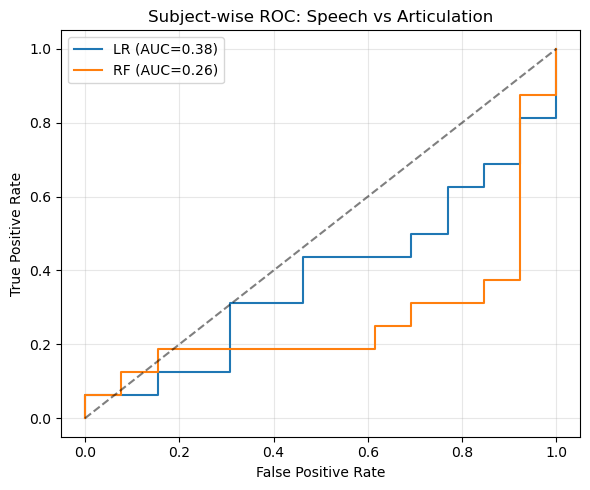

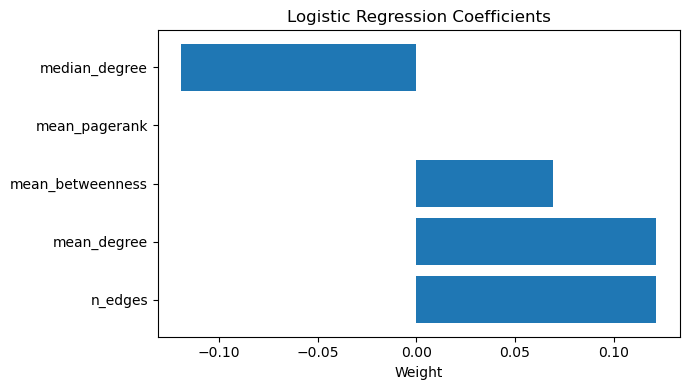

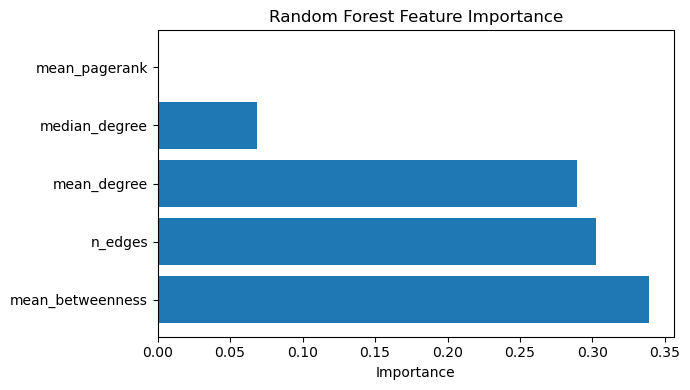

Saved: models\task_classifier_logreg.joblib
Saved: models\task_classifier_rf.joblib


In [41]:
# ============================================
# Title: ROC Curves & Model Interpretability Plots
# Description: Plot ROC curves and feature effects; save to figures/.
# Code Attribution / Sources:
# - Matplotlib usage (matplotlib docs).
# - LR coefficients and RF feature importances (sklearn docs).
# ============================================

import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc
from pathlib import Path
import joblib

FIG_DIR = Path("figures")
FIG_DIR.mkdir(parents=True, exist_ok=True)

# ROC curves
fpr_lr, tpr_lr, _ = roc_curve(y, proba_lr)
roc_lr = auc(fpr_lr, tpr_lr)
fpr_rf, tpr_rf, _ = roc_curve(y, proba_rf)
roc_rf = auc(fpr_rf, tpr_rf)

plt.figure(figsize=(6,5))
plt.plot(fpr_lr, tpr_lr, label=f"LR (AUC={roc_lr:.2f})")
plt.plot(fpr_rf, tpr_rf, label=f"RF (AUC={roc_rf:.2f})")
plt.plot([0,1],[0,1], "k--", alpha=0.5)
plt.xlabel("False Positive Rate"); plt.ylabel("True Positive Rate")
plt.title("Subject-wise ROC: Speech vs Articulation")
plt.legend(); plt.grid(alpha=0.3)
plt.tight_layout()
plt.savefig(FIG_DIR / "roc_subjectwise.png", dpi=150)
plt.show()

# LR coefficients (with scaling refit on full data)
best_lr.fit(X, y)  # fit to full dataset for final coefficients
coef = best_lr.named_steps["clf"].coef_[0]
coef_df = pd.DataFrame({"feature": feature_cols, "coef": coef}).sort_values("coef", ascending=False)

plt.figure(figsize=(7,4))
plt.barh(coef_df["feature"], coef_df["coef"])
plt.title("Logistic Regression Coefficients")
plt.xlabel("Weight")
plt.tight_layout()
plt.savefig(FIG_DIR / "lr_coefficients.png", dpi=150)
plt.show()

# RF feature importance
best_rf.fit(X, y)
imp = best_rf.named_steps["clf"].feature_importances_
imp_df = pd.DataFrame({"feature": feature_cols, "importance": imp}).sort_values("importance", ascending=False)

plt.figure(figsize=(7,4))
plt.barh(imp_df["feature"], imp_df["importance"])
plt.title("Random Forest Feature Importance")
plt.xlabel("Importance")
plt.tight_layout()
plt.savefig(FIG_DIR / "rf_importance.png", dpi=150)
plt.show()

# Save models to repository
MODELS_DIR = Path("models")
MODELS_DIR.mkdir(exist_ok=True)
joblib.dump(best_lr, MODELS_DIR / "task_classifier_logreg.joblib")
joblib.dump(best_rf, MODELS_DIR / "task_classifier_rf.joblib")
print("Saved:", MODELS_DIR / "task_classifier_logreg.joblib")
print("Saved:", MODELS_DIR / "task_classifier_rf.joblib")


In [45]:
# ============================================
# Title: Build Region-level Feature Matrix from Node Metrics
# Description: Loads per-(subject, task) node metrics CSVs and pivots
#              region-level metrics (degree, betweenness) into wide features.
# Code Attribution:
# - pandas pivot_table, merge, and glob usage from pandas official docs.
# - Node metrics produced earlier in this notebook using NetworkX
#   (Rubinov & Sporns, 2010; Bullmore & Sporns, 2009 for interpretation).
# ============================================
import pandas as pd
import numpy as np
from pathlib import Path
import glob
import re

DERIV = Path("data/derivatives")
TOPK = 5  

# Helper to extract subject/task from filename
pat = re.compile(r"metrics_(sub-[A-Za-z0-9]+)_(Alice|Articulation)_topk(\d+)\.csv$")

files = sorted(glob.glob(str(DERIV / f"metrics_sub-*_*_topk{TOPK}.csv")))
print(f"Found {len(files)} metrics files (expect ~2 per subject).")

rows = []
frames_deg = []
frames_btw = []
frames_pr = []

for f in files:
    m = pat.search(Path(f).name)
    if not m:
        continue
    sub_id, task, topk_str = m.groups()
    df = pd.read_csv(f)
    # Ensure expected columns exist
    assert {"label","degree","betweenness","pagerank"}.issubset(df.columns), f"Missing cols in {f}"

    # Degree wide
    deg_w = df.pivot_table(index=None, columns="label", values="degree").add_prefix("deg|")
    # Betweenness wide
    btw_w = df.pivot_table(index=None, columns="label", values="betweenness").add_prefix("btw|")
    # PageRank
    pr_w  = df.pivot_table(index=None, columns="label", values="pagerank").add_prefix("pr|")

    # Add identifiers
    deg_w["subject"] = sub_id
    deg_w["task"]    = task
    btw_w["subject"] = sub_id
    btw_w["task"]    = task
    pr_w["subject"] = sub_id; pr_w["task"] = task

    # Merge metrics for same run
    run_wide = pd.merge(deg_w, btw_w, on=["subject","task"], how="inner")
    run_wide = run_wide.merge(pr_w, on=["subject","task"], how="inner")

    rows.append(run_wide)

if not rows:
    raise RuntimeError("No metrics_* CSVs found. ensure you run the per-subject pipeline first")

X_wide = pd.concat(rows, ignore_index=True)

# Sort columns for consistency
id_cols = ["subject","task"]
feature_cols = sorted([c for c in X_wide.columns if c not in id_cols])
X_wide = X_wide[id_cols + feature_cols]

print(f"Wide feature matrix shape: {X_wide.shape} (rows = runs; cols = {len(feature_cols)} features)")
display(X_wide.iloc[:3, :10])

# Encode target and groups
X_feats = X_wide[feature_cols].copy()
y       = X_wide["task"].map({"Articulation":0, "Alice":1}).values
groups  = X_wide["subject"].astype(str).values

# Save a copy for provenance
X_wide.to_parquet(DERIV / "region_level_features.parquet", index=False)
print("Saved parquet", DERIV / "region_level_features.parquet")


Found 29 metrics files (expect ~2 per subject).
Wide feature matrix shape: (29, 202) (rows = runs; cols = 200 features)


label,subject,task,btw|7Networks_LH_Cont_Cing_1,btw|7Networks_LH_Cont_PFCl_1,btw|7Networks_LH_Cont_Par_1,btw|7Networks_LH_Cont_pCun_1,btw|7Networks_LH_Default_PFC_1,btw|7Networks_LH_Default_PFC_2,btw|7Networks_LH_Default_PFC_3,btw|7Networks_LH_Default_PFC_4
0,sub-01,Alice,0.021885,0.015062,0.010307,0.024023,0.033760,0.016441,0.000000,0.009716
1,sub-01,Articulation,0.025496,0.030475,0.000936,0.047980,0.014480,0.005127,0.000929,0.048093
2,sub-03,Alice,0.089244,0.093503,0.058933,0.009352,0.002814,0.026495,0.010911,0.040210


Saved parquet -> data\derivatives\region_level_features.parquet


In [47]:
# ============================================
# Title: Subject-centered Feature Normalization
# Description: Center features within each subject using the subject series
#              as group key (avoids KeyErrors on dropping columns).
# ============================================
import pandas as pd

# Safety checks
assert len(X_feats) == len(X_wide), "Row count mismatch between X_feats and X_wide."
assert "subject" in X_wide.columns, "X_wide must contain a 'subject' column."

# Group key is the subject series (not a column in X_feats)
gkey = X_wide["subject"].astype(str)

# Compute per-subject means for each feature (row-aligned via transform)
means_by_subject = X_feats.groupby(gkey).transform("mean")

# Centered features: subtract within-subject mean
X_centered = X_feats - means_by_subject

print("X_feats shape:", X_feats.shape)
print("X_centered shape:", X_centered.shape)
display(X_centered.iloc[:3, :5])



X_feats shape: (29, 200)
X_centered shape: (29, 200)


label,btw|7Networks_LH_Cont_Cing_1,btw|7Networks_LH_Cont_PFCl_1,btw|7Networks_LH_Cont_Par_1,btw|7Networks_LH_Cont_pCun_1,btw|7Networks_LH_Default_PFC_1
0,-0.001805,-0.007706,0.004686,-0.011978,0.009640
1,0.001805,0.007706,-0.004686,0.011978,-0.009640
2,0.014996,0.045312,-0.043023,0.004547,-0.002446


In [49]:
# ============================================
# Title: L1-regularized Logistic Regression (GroupKFold CV)
# Description: Sparse LR (L1) to select informative parcels; group-wise CV.
# Code Attribution:
# - scikit-learn Pipeline, GroupKFold, GridSearchCV usage from official docs.
# - LogisticRegression(solver='saga', penalty='l1') per sklearn guidance.
# - Reference: Pedregosa et al., 2011 (JMLR).
# ============================================
from sklearn.model_selection import GroupKFold, GridSearchCV, cross_val_predict
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, roc_auc_score, classification_report, confusion_matrix

cv = GroupKFold(n_splits=5)

pipe_l1 = Pipeline([
    ("scaler", StandardScaler(with_mean=True, with_std=True)),
    ("clf", LogisticRegression(
        penalty="l1",
        solver="saga",
        max_iter=2000,
        random_state=42,
        n_jobs=-1
    ))
])

param_grid = {
    "clf__C": [0.01, 0.05, 0.1, 0.5, 1.0, 2.0, 5.0]  # tune sparsity
}

def evaluate_model(Xmat, label="RAW"):
    grid = GridSearchCV(
        estimator=pipe_l1,
        param_grid=param_grid,
        scoring={"acc":"accuracy", "roc":"roc_auc"},
        refit="roc",
        cv=cv,
        n_jobs=-1,
        verbose=0
    )
    grid.fit(Xmat, y, groups=groups)
    print(f"\n[{label}] Best ROC-AUC: {grid.best_score_:.3f} | Best C: {grid.best_params_['clf__C']}")
    # Subject-wise CV predictions
    proba = cross_val_predict(grid.best_estimator_, Xmat, y, groups=groups, cv=cv, method="predict_proba")[:,1]
    pred  = (proba >= 0.5).astype(int)
    acc   = accuracy_score(y, pred)
    roc   = roc_auc_score(y, proba)
    print(f"[{label}] CV Accuracy: {acc:.3f} | ROC-AUC: {roc:.3f}")
    print("Confusion matrix:\n", confusion_matrix(y, pred))
    print("Classification report:\n", classification_report(y, pred, target_names=["Articulation","Alice"]))
    return grid, pred, proba

grid_raw,  pred_raw,  proba_raw  = evaluate_model(X_feats,     label="RAW FEATURES")
grid_cent, pred_cent, proba_cent = evaluate_model(X_centered,  label="SUBJECT-CENTERED")



[RAW FEATURES] Best ROC-AUC: 0.750 | Best C: 0.5
[RAW FEATURES] CV Accuracy: 0.759 | ROC-AUC: 0.774
Confusion matrix:
 [[ 7  6]
 [ 1 15]]
Classification report:
               precision    recall  f1-score   support

Articulation       0.88      0.54      0.67        13
       Alice       0.71      0.94      0.81        16

    accuracy                           0.76        29
   macro avg       0.79      0.74      0.74        29
weighted avg       0.79      0.76      0.75        29


[SUBJECT-CENTERED] Best ROC-AUC: 0.500 | Best C: 0.01
[SUBJECT-CENTERED] CV Accuracy: 0.483 | ROC-AUC: 0.389
Confusion matrix:
 [[ 2 11]
 [ 4 12]]
Classification report:
               precision    recall  f1-score   support

Articulation       0.33      0.15      0.21        13
       Alice       0.52      0.75      0.62        16

    accuracy                           0.48        29
   macro avg       0.43      0.45      0.41        29
weighted avg       0.44      0.48      0.43        29




Selected model: RAW FEATURES  |  Best ROC-AUC (CV mean): 0.750  |  C=0.5


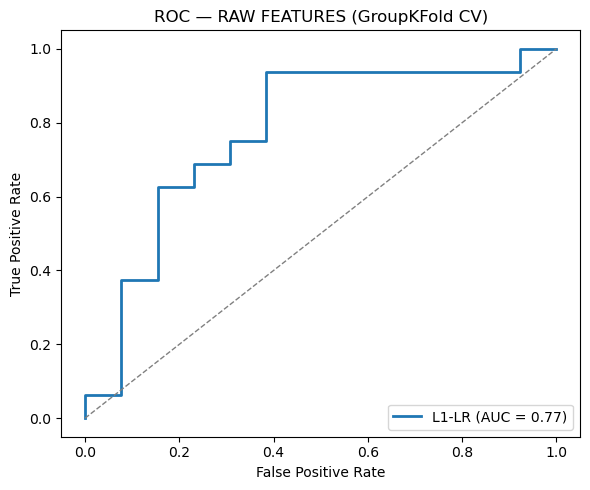

Saved ROC plot -> figures\roc_l1_subjectwise.png


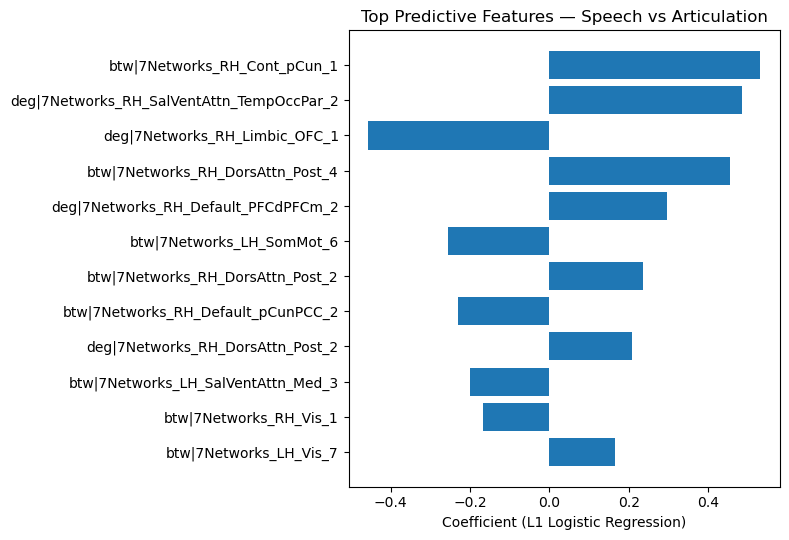

Saved coefficients plot -> figures\coef_top_l1.png


,feature,coef,abs_coef
0,btw|7Networks_RH_Cont_pCun_1,0.532044,0.532044
1,deg|7Networks_RH_SalVentAttn_TempOccPar_2,0.484697,0.484697
2,deg|7Networks_RH_Limbic_OFC_1,-0.457128,0.457128
3,btw|7Networks_RH_DorsAttn_Post_4,0.454552,0.454552
4,deg|7Networks_RH_Default_PFCdPFCm_2,0.296857,0.296857
5,btw|7Networks_LH_SomMot_6,-0.256710,0.256710
6,btw|7Networks_RH_DorsAttn_Post_2,0.236959,0.236959
7,btw|7Networks_RH_Default_pCunPCC_2,-0.229889,0.229889
8,deg|7Networks_RH_DorsAttn_Post_2,0.207733,0.207733
9,btw|7Networks_LH_SalVentAttn_Med_3,-0.200879,0.200879


In [59]:
# ============================================
# Title: Best L1-LR Model Selection + ROC & Importances
# Description: Select the best subject-wise CV model (L1 logistic), refit on all data,
#              then plot ROC curve (from CV probabilities) and top coefficients.
# Code Attribution:
#  - scikit-learn examples (Pedregosa et al., 2011)
#  - scikit-learn docs: LogisticRegression, GridSearchCV, cross_val_predict, metrics
#  - GroupKFold pattern from sklearn model selection guides
# ============================================

import os
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, roc_auc_score

# choose the better grid based on ROC-AUC (mean CV) 
best_label, best_grid, best_pred, best_proba, X_choice = None, None, None, None, None

# Pull scores (already printed earlier); choose by .best_score_ (refit='roc')
raw_score  = grid_raw.best_score_
cent_score = grid_cent.best_score_

if cent_score >= raw_score:
    best_label = "SUBJECT-CENTERED"
    best_grid, best_pred, best_proba = grid_cent, pred_cent, proba_cent
    X_choice = X_centered
else:
    best_label = "RAW FEATURES"
    best_grid, best_pred, best_proba = grid_raw, pred_raw, proba_raw
    X_choice = X_feats

print(f"\nSelected model: {best_label}  |  Best ROC-AUC (CV mean): {best_grid.best_score_:.3f}  |  C={best_grid.best_params_['clf__C']}")

# refit the best estimator on ALL data for coefficients 
# (We refit on the feature set that won)
best_est = best_grid.best_estimator_
best_est.fit(X_choice, y)  #  training on all for stable coefs

# Utility: feature names (works if X_choice is a DataFrame else make a list)
if hasattr(X_choice, "columns"):
    feature_names = np.array(X_choice.columns)
else:
    feature_names = np.array([f"f{i}" for i in range(X_choice.shape[1])])

# Extract coefficients from the logistic step inside the pipeline
logreg = best_est.named_steps["clf"]
coefs = logreg.coef_.ravel()


os.makedirs("figures", exist_ok=True)

# - ROC curve from subject-wise CV probabilities 
fpr, tpr, _ = roc_curve(y, best_proba)
auc = roc_auc_score(y, best_proba)

plt.figure(figsize=(6,5))
plt.plot(fpr, tpr, lw=2, label=f"L1-LR (AUC = {auc:.2f})")
plt.plot([0,1],[0,1], "--", color="gray", lw=1)
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title(f"ROC — {best_label} (GroupKFold CV)")
plt.legend(loc="lower right")
plt.tight_layout()
roc_path = os.path.join("figures", "roc_l1_subjectwise.png")
plt.savefig(roc_path, dpi=150)
plt.show()
print(f"Saved ROC plot -> {roc_path}")

# - Top-K absolute coefficients (feature importances)
K = 12
top_idx = np.argsort(np.abs(coefs))[-K:][::-1]
top_feats = feature_names[top_idx]
top_vals  = coefs[top_idx]

plt.figure(figsize=(8,5.5))
plt.barh(top_feats[::-1], top_vals[::-1])
plt.xlabel("Coefficient (L1 Logistic Regression)")
plt.title("Top Predictive Features — Speech vs Articulation")
plt.tight_layout()
coef_path = os.path.join("figures", "coef_top_l1.png")
plt.savefig(coef_path, dpi=150)
plt.show()
print(f"Saved coefficients plot -> {coef_path}")

# print a compact table 
import pandas as pd
imp_table = pd.DataFrame({"feature": top_feats, "coef": top_vals, "abs_coef": np.abs(top_vals)}).sort_values("abs_coef", ascending=False)
display(imp_table)


In [132]:
# ============================================
# Title: Subject-centered Feature Normalization (Robust)
# Description: Center features within each subject to reduce
#              between-subject baselines and emphasize task differences.
# Code Attribution:
# - Group-wise transform pattern from pandas docs.
# - Keeps grouping key separate to avoid KeyErrors.
# ============================================

# Sanity checks
assert "subject" in X_wide.columns, "X_wide must contain a 'subject' column."
assert set(X_feats.columns) <= set(X_wide.columns) | {"subject","task"}, "Feature columns must come from X_wide."

# Build a temporary frame with features + subject for grouping
tmp = X_feats.copy()
tmp["subject"] = X_wide["subject"].values

# compute per-subject means for feature columns only
feat_cols = X_feats.columns.tolist()
means = tmp.groupby("subject")[feat_cols].transform("mean")

# Center: subtract within-subject mean keep original column order
X_centered = X_feats[feat_cols] - means[feat_cols]

print("Centered feature sample (first 5 cols):")
display(X_centered.iloc[:3, :5])
print("Shapes -> X_centered:", X_centered.shape, "| X_feats:", X_feats.shape)


Centered feature sample (first 5 cols):


label,btw|7Networks_LH_Cont_Cing_1,btw|7Networks_LH_Cont_PFCl_1,btw|7Networks_LH_Cont_Par_1,btw|7Networks_LH_Cont_pCun_1,btw|7Networks_LH_Default_PFC_1
0,-0.001805,-0.007706,0.004686,-0.011978,0.009640
1,0.001805,0.007706,-0.004686,0.011978,-0.009640
2,0.014996,0.045312,-0.043023,0.004547,-0.002446


Shapes -> X_centered: (29, 200) | X_feats: (29, 200)
